In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker
import os,sys
import numpy as np
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc, average_precision_score
import pandas as pd
import os
from typing import List, Dict
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple

import matplotlib.pyplot as plt
import seaborn as sns  
import matplotlib.ticker as mticker
warnings.filterwarnings("ignore")

In [2]:
def merge_fold_predictions(base_path: str, model_types: List[str], num_folds: int = 10) -> Dict[str, pd.DataFrame]:
    """
    合并不同模型类型的交叉验证预测结果
    
    Parameters:
    -----------
    base_path : str
        预测文件的基础路径
    model_types : list
        模型类型列表 (例如: ['C-P', 'C', 'P'])
    num_folds : int
        交叉验证折数，默认为10
    
    Returns:
    --------
    Dict[str, pd.DataFrame]
        键为模型类型，值为合并后的DataFrame的字典
    """
    results = {}
    
    for model_type in model_types:
        # 构建文件路径列表
        csv_files = [
            os.path.join(base_path, f"{model_type}-checkpoints", f"fold_{fold}_predictions.csv")
            for fold in range(1, num_folds + 1)
        ]
        
        # 读取并合并CSV文件
        dfs = []
        for file_path in csv_files:
            try:
                df = pd.read_csv(file_path)
                df['fold'] = int(os.path.basename(file_path).split('_')[1])  # 添加fold编号
                df['model_type'] = model_type  # 添加模型类型标识
                dfs.append(df)
            except Exception as e:
                print(f"Error reading {file_path}: {str(e)}")
                continue
        
        if dfs:
            # 合并所有DataFrame
            combined_df = pd.concat(dfs, ignore_index=True)
            
            # 保存合并后的文件
            output_file = os.path.join(base_path,f"{model_type}_AUC_PRC_data.csv")
            combined_df.to_csv(output_file, index=False)
            print(f"Successfully saved {output_file}")
            
            results[model_type] = combined_df
        else:
            print(f"No valid data found for model type: {model_type}")
    
    return results

# 配置参数
base_path = "/hpcfs/fhome/yangchh/workdir/self/TLCP-EPE/DLs/model-compare"
# base_path = "/hpcfs/fhome/yangchh/workdir/self/TLCP-EPE/DLs/BiGRU-Attention-MLP"
model_types = ['BiGRU-Attention-MLP', 'BiGRU-MLP', 'Attention-MLP', 'MLP',]
# model_types = ['TLCP-EPE', 'TLP-EPE']  #'TLC-EPE' 'TLP-EPE'
    
try:
    # 执行合并操作
    results = merge_fold_predictions(base_path, model_types)
        
    # 输出基本统计信息
    for model_type, df in results.items():
        print(f"\nStatistics for {model_type} model:")
        print(f"Total samples: {len(df)}")
        print(f"Folds present: {sorted(df['fold'].unique())}")
        print(f"Columns: {df.columns.tolist()}")
            
except Exception as e:
        print(f"An error occurred: {str(e)}")

Successfully saved /hpcfs/fhome/yangchh/workdir/self/TLCP-EPE/DLs/model-compare/BiGRU-Attention-MLP_AUC_PRC_data.csv
Successfully saved /hpcfs/fhome/yangchh/workdir/self/TLCP-EPE/DLs/model-compare/BiGRU-MLP_AUC_PRC_data.csv
Successfully saved /hpcfs/fhome/yangchh/workdir/self/TLCP-EPE/DLs/model-compare/Attention-MLP_AUC_PRC_data.csv
Successfully saved /hpcfs/fhome/yangchh/workdir/self/TLCP-EPE/DLs/model-compare/MLP_AUC_PRC_data.csv

Statistics for BiGRU-Attention-MLP model:
Total samples: 857
Folds present: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Columns: ['fold', 'y_true', 'y_pred', 'prob_class_0', 'prob_class_1', 'model_type']

Statistics for BiGRU-MLP model:
Total samples: 857
Folds present: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Columns: ['fold', 'y_true', 'y_pred', 'prob_class_0', 'prob_class_1', 'model_type']

Statistics for Attention-MLP model:
Total samples: 857
Folds present: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Columns: ['fold', 'y_true', 'y_pred', 'prob_class_0', 'prob_class_1', 'model_type']



In [3]:
results.keys()

dict_keys(['TLCP-EPE'])

In [3]:
def load_and_process_data(file_paths: Dict[str, str]) -> Dict[str, Dict[str, List]]:
    """
    加载并处理多个模型的数据，计算ROC和PRC曲线数据
    """
    results = {}
    mean_fpr = np.linspace(0, 1, 100)
    
    for model_name, file_path in file_paths.items():
        if not os.path.exists(file_path):
            print(f"警告：文件 {file_path} 不存在，跳过该模型")
            continue
            
        try:
            df = pd.read_csv(file_path)
            required_columns = {'fold', 'y_true', 'prob_class_1'}
            if not required_columns.issubset(df.columns):
                print(f"警告：文件 {file_path} 缺少必要的列")
                continue
                
            folds = sorted(df['fold'].unique())
            tprs = []
            aucs = []
            precisions = []
            recalls = []
            pr_aucs = []
            
            # 新增：存储每个fold的原始曲线数据
            tpr_list = []
            fpr_list = []
            precision_list = []
            recall_list = []
            
            # 计算每个fold的ROC和PRC数据
            for fold in folds:
                fold_data = df[df['fold'] == fold]
                y_true_fold = fold_data['y_true'].values
                prob_class_1_fold = fold_data['prob_class_1'].values
                
                # ROC数据
                fpr, tpr, _ = roc_curve(y_true_fold, prob_class_1_fold)
                roc_auc = auc(fpr, tpr)
                aucs.append(roc_auc)
                interp_tpr = np.interp(mean_fpr, fpr, tpr)
                interp_tpr[0] = 0.0
                tprs.append(interp_tpr)
                
                # 新增：存储原始ROC曲线数据
                fpr_list.append(fpr)
                tpr_list.append(tpr)
                
                # PRC数据
                precision, recall, _ = precision_recall_curve(y_true_fold, prob_class_1_fold)
                pr_auc = average_precision_score(y_true_fold, prob_class_1_fold)
                pr_aucs.append(pr_auc)
                
                # 对precision进行插值（用于平均计算）
                mean_recall = np.linspace(0, 1, 100)
                interp_precision = np.interp(mean_recall, recall[::-1], precision[::-1])
                precisions.append(interp_precision)
                
                # 新增：存储原始PRC曲线数据
                precision_list.append(precision)
                recall_list.append(recall)
            
            # 计算平均值和标准差
            mean_tpr = np.mean(tprs, axis=0)
            mean_tpr[-1] = 1.0
            mean_auc = np.mean(aucs)
            std_auc = np.std(aucs)
            
            mean_precision = np.mean(precisions, axis=0)
            mean_pr_auc = np.mean(pr_aucs)
            std_pr_auc = np.std(pr_aucs)
            
            results[model_name] = {
                'mean_fpr': mean_fpr,
                'mean_tpr': mean_tpr,
                'mean_auc': mean_auc,
                'std_auc': std_auc,
                'mean_recall': mean_recall,
                'mean_precision': mean_precision,
                'mean_pr_auc': mean_pr_auc,
                'std_pr_auc': std_pr_auc,
                # 新增：存储每个fold的原始曲线数据
                'tpr_list': tpr_list,
                'fpr_list': fpr_list,
                'precision_list': precision_list,
                'recall_list': recall_list
            }
            
        except Exception as e:
            print(f"处理 {model_name} 模型时发生错误：{str(e)}")
            continue
    
    return results

In [4]:

# 文件路径配置
base_path = "/hpcfs/fhome/yangchh/workdir/self/TLCP-EPE/DLs/model-compare"
# 确保文件路径字典和颜色字典的键名一致
file_paths = {
    'BiGRU-Attention-MLP': f"{base_path}/BiGRU-Attention-MLP_AUC_PRC_data.csv",
    'BiGRU-MLP': f"{base_path}/BiGRU-MLP_AUC_PRC_data.csv",
    'Attention-MLP': f"{base_path}/Attention-MLP_AUC_PRC_data.csv",
    'MLP': f"{base_path}/MLP_AUC_PRC_data.csv"
}
colors = {
    'MLP': '#006D77',
    'Attention-MLP':'#4A7047',
    'BiGRU-MLP': '#9B2226', 
    'BiGRU-Attention-MLP': '#2E5894'
}

# file_paths = {
#     'TLCP-EPE': f"{base_path}/TLCP-EPE_AUC_PRC_data.csv",
#     # 'TLC-EPE': f"{base_path}/TLC-EPE_AUC_PRC_data.csv",
#     'TLP-EPE': f"{base_path}/TLP-EPE_AUC_PRC_data.csv"
# }
# colors = {
#     'TLCP-EPE': '#8B4513',
#     # 'TLC-EPE':'#4682B4',
#     'TLP-EPE': '#3CB371'
# }

results = load_and_process_data(file_paths)

In [5]:

results.keys()

dict_keys(['BiGRU-Attention-MLP', 'BiGRU-MLP', 'Attention-MLP', 'MLP'])

In [6]:
results

{'TLCP-EPE': {'mean_fpr': array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
         0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
         0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
         0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
         0.2020202 , 0.21212121, 0.22222222, 0.23232323, 0.24242424,
         0.25252525, 0.26262626, 0.27272727, 0.28282828, 0.29292929,
         0.3030303 , 0.31313131, 0.32323232, 0.33333333, 0.34343434,
         0.35353535, 0.36363636, 0.37373737, 0.38383838, 0.39393939,
         0.4040404 , 0.41414141, 0.42424242, 0.43434343, 0.44444444,
         0.45454545, 0.46464646, 0.47474747, 0.48484848, 0.49494949,
         0.50505051, 0.51515152, 0.52525253, 0.53535354, 0.54545455,
         0.55555556, 0.56565657, 0.57575758, 0.58585859, 0.5959596 ,
         0.60606061, 0.61616162, 0.62626263, 0.63636364, 0.64646465,
         0.65656566, 0.66666667, 0.67676768, 0.68686869, 0.6969697 ,
         0

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# tlcp_epe = pd.read_csv("/hpcfs/fhome/yangchh/workdir/self/TLCP-EPE/DLs/BiGRU-Attention-MLP/TLCP-EPE-checkpoints/Finetune_CaLM+ProtT5.csv")
# tlcp_epe["embedding_model"] = "TLCP-EPE"

# tlp_epe = pd.read_csv("/hpcfs/fhome/yangchh/workdir/self/TLCP-EPE/DLs/BiGRU-Attention-MLP/TLP-EPE-checkpoints/prot_t5_xl_uniref50.csv")
# tlp_epe["embedding_model"] = "TLP-EPE"

# tlc_epe = pd.read_csv("/hpcfs/fhome/yangchh/workdir/self/TLCP-EPE/DLs/BiGRU-Attention-MLP/TLC-EPE-checkpoints/huggingface_calm.csv")
# tlc_epe["embedding_model"] = "TLC-EPE"


# 读取CSV文件 
mlp_df = pd.read_csv('/hpcfs/fhome/yangchh/workdir/self/TLCP-EPE/DLs/model-compare/MLP-checkpoints/Finetune_CaLM+ProtT5.csv')
mlp_df["embedding_model"]="MLP"

A_mlp_df = pd.read_csv('/hpcfs/fhome/yangchh/workdir/self/TLCP-EPE/DLs/model-compare/Attention-MLP-checkpoints/Finetune_CaLM+ProtT5.csv')
A_mlp_df["embedding_model"]="Attention-MLP"

B_mlp_df = pd.read_csv('/hpcfs/fhome/yangchh/workdir/self/TLCP-EPE/DLs/model-compare/BiGRU-MLP-checkpoints/Finetune_CaLM+ProtT5.csv')
B_mlp_df["embedding_model"]="BiGRU-MLP"

B_A_mlp_df = pd.read_csv('/hpcfs/fhome/yangchh/workdir/self/TLCP-EPE/DLs/model-compare/BiGRU-Attention-MLP-checkpoints/Finetune_CaLM+ProtT5.csv')
B_A_mlp_df["embedding_model"]="BiGRU-Attention-MLP"

# 准备数据
metrics = ['auc', 'accuracy', 'f1', 'mcc'] # ,  
models = ['BiGRU-Attention-MLP', 'BiGRU-MLP', 'Attention-MLP', 'MLP']  # , 

# models = ['TLCP-EPE', 'TLP-EPE'] # "TLP-EPE" 'TLC-EPE',

# 创建一个新的DataFrame用于绘图
plot_data = []
for metric in metrics:
    for model in models:
        
        if model == 'BiGRU-Attention-MLP':
            data = B_A_mlp_df[metric]

        elif model == 'BiGRU-MLP':
            data = B_mlp_df[metric]

        elif model == 'Attention-MLP':
            data = A_mlp_df[metric]

        elif model == 'MLP':
            data = mlp_df[metric]

        # if model == "TLCP-EPE":
        #     data = tlcp_epe[metric]
        # # elif model == 'TLC-EPE':
        # #     data = tlc_epe[metric]
        # elif model == "TLP-EPE":
        #     data = tlp_epe[metric]
       
        for value in data:
            plot_data.append({
                'Metric': metric.upper() if metric == 'auc' else metric.capitalize(),
                'Value': value,
                'Model': model
            })

plot_df = pd.DataFrame(plot_data)
plot_df["Metric"] = plot_df["Metric"].str.replace( "Accuracy", "ACC" )
plot_df["Metric"] = plot_df["Metric"].str.replace( "Mcc", "MCC" )


# plot_df["Model"] = plot_df["Model"].str.replace( "MLP", "Model1" )
# plot_df["Model"] = plot_df["Model"].str.replace( "BiGRU-MLP", "BiGRU-MLP" )
# plot_df["Model"] = plot_df["Model"].str.replace( "BiGRU-Attention-Model1", "BiGRU-Attention-MLP" )

In [9]:
set(plot_df["Metric"])

{'ACC', 'F1', 'MCC', 'Precision', 'Recall'}

In [12]:
aa = plot_df[plot_df["Model"]=="BiGRU-MLP"]

In [18]:
plot_df

,Metric,Value,Model
0,Recall,0.718494,TLCP-EPE
1,Recall,0.820786,TLCP-EPE
2,Recall,0.777174,TLCP-EPE
3,Recall,0.796196,TLCP-EPE
4,Recall,0.744565,TLCP-EPE
...,...,...,...
145,MCC,0.632599,TLP-EPE
146,MCC,0.555405,TLP-EPE
147,MCC,0.626670,TLP-EPE
148,MCC,0.510841,TLP-EPE


In [7]:
plot_df

NameError: name 'plot_df' is not defined

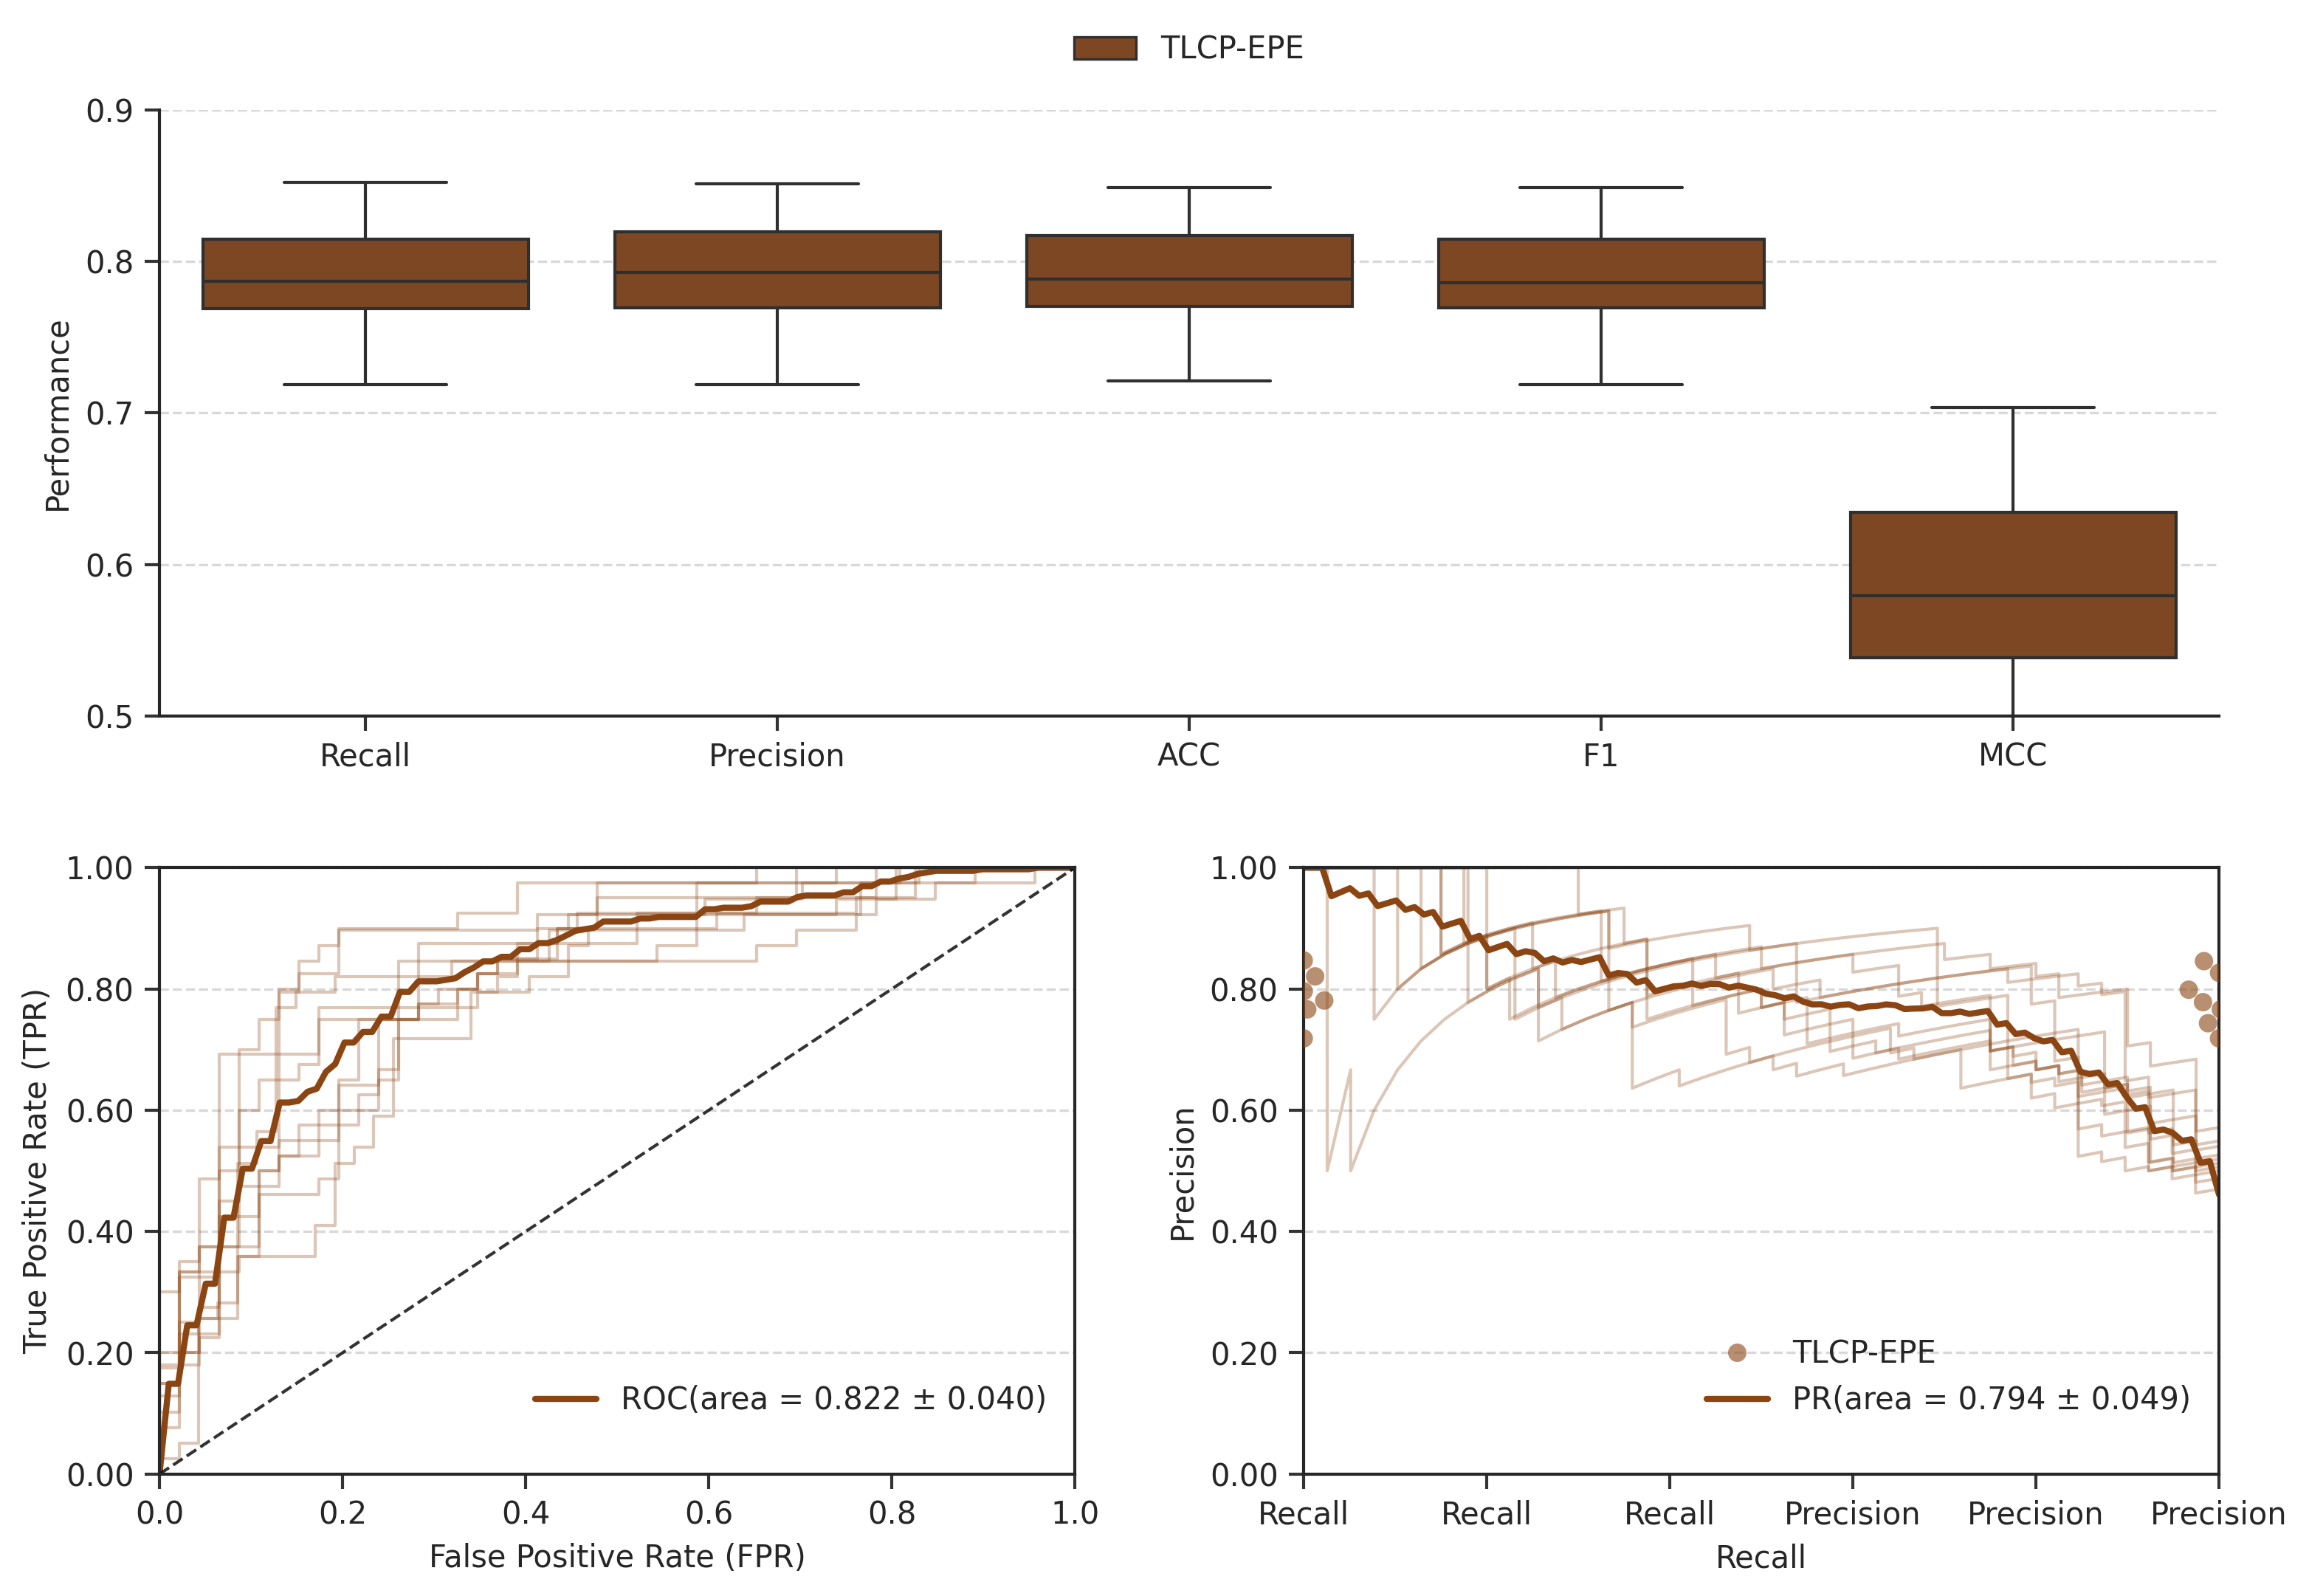

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker
import numpy as np
from matplotlib.patches import Rectangle
import pandas as pd

# ========== 全局样式设置 ==========
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'
sns.set_theme(style="ticks", context="paper")

# 自定义调色板（与第一个图一致）
custom_palette = [
    '#8A9DBA',  # Silver Blue
    '#5C7AA7',  # Light Steel Blue
    '#2E5894',  # Deep Blue
    '#C0392B',  # Red
    '#27AE60'   # Green
]

# ========== 字体大小统一设置 ==========
label_fontsize = 10
tick_labelsize = 10
legend_fontsize = 10
title_fontsize = 10

# ========== 创建图形：紧凑布局 ==========
fig, (ax3, (ax1, ax2)) = plt.subplots(
    2, 2,
    figsize=(12, 8),   
    dpi=300,
    gridspec_kw={'height_ratios': [1, 1], 'width_ratios': [1, 1], 'hspace': 0.25, 'wspace': 0.25}
)


# 重新调整子图布局
# ax3 占据第一行（跨两列）
ax3 = plt.subplot2grid((2, 2), (0, 0), colspan=2, fig=fig)
# ax1 和 ax2 在第二行
ax1 = plt.subplot2grid((2, 2), (1, 0), fig=fig)
ax2 = plt.subplot2grid((2, 2), (1, 1), fig=fig)

# ========== 子图 C：条形图 ==========
# bar = sns.barplot(
#     x="Metric", y="Value", hue="Model", data=plot_df,
#     palette=colors,  # 使用与子图12一致的颜色
#     ax=ax3,
#     linewidth=0,
#     width=0.3,
#     saturation=1.0,
#     dodge=True,
#     gap=0.15,
#     errorbar=None  # 明确指定不显示误差棒
# )

# 第三个子图 - 箱线图
sns.boxplot(x='Metric', y='Value', hue='Model', data=plot_df,
           palette=colors, width=0.79, showfliers=False, ax=ax3)

sns.swarmplot(x='Metric', y='Value', hue='Model', data=plot_df,
              palette=colors, dodge=True, size=6, alpha=0.6)



ax3.set_xlabel('', fontsize=label_fontsize)
ax3.set_ylabel('Performance', fontsize=label_fontsize)
ax3.set_ylim(0.5, 0.9)
# y_ticks = np.linspace(0.5, 0.9, 10)

ax3.set_yticks(np.arange(0.5, 0.911, 0.1))

# ax3.set_yticks(y_ticks)
ax3.tick_params(axis='both', labelsize=tick_labelsize, color='#333333')
ax3.grid(True, axis='y', linestyle='--', alpha=0.3, color='gray', linewidth=0.8)
ax3.set_axisbelow(True)
# ax3.text(-0.03, 1.02, 'C', transform=ax3.transAxes, fontsize=title_fontsize, fontweight='bold', va='top')

# ========== 图例子图 C ==========
handles, labels = ax3.get_legend_handles_labels()
ax3.legend(
    handles[:len(colors)],
    labels[:len(colors)],
    fontsize=legend_fontsize,
    frameon=False,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.17),
    ncol=4
)
sns.despine(ax=ax3, top=True, right=True)

# ========== 子图 A：模型三的十折ROC曲线 ==========
model_name = 'TLCP-EPE'
model_data = results[model_name]

# 绘制十折曲线
for fold in range(len(model_data['tpr_list'])):
    ax1.plot(model_data['fpr_list'][fold], model_data['tpr_list'][fold],
             color=colors[model_name],
             lw=1,
             alpha=0.3)

# 绘制平均曲线
ax1.plot(model_data['mean_fpr'], model_data['mean_tpr'],
         color=colors[model_name],
         lw=2,
         alpha=1.0,
         label=f'ROC(area = {model_data["mean_auc"]:.3f} ± {model_data["std_auc"]:.3f})')

ax1.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--', alpha=0.8)
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.0])
ax1.set_xlabel('False Positive Rate (FPR)', fontsize=label_fontsize)
ax1.set_ylabel('True Positive Rate (TPR)', fontsize=label_fontsize)
ax1.grid(True, axis='y', linestyle='--', alpha=0.3, color='gray', linewidth=0.8)
ax1.set_axisbelow(True)
ax1.tick_params(axis='both', labelsize=tick_labelsize, color='#333333')
ax1.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))
ax1.set_xticks(np.arange(0, 1.2, 0.2))
ax1.set_yticks(np.arange(0, 1.2, 0.2))

# ========== 子图 B：模型三的十折PRC曲线 ==========
# 绘制十折曲线
for fold in range(len(model_data['precision_list'])):
    ax2.plot(model_data['recall_list'][fold], model_data['precision_list'][fold],
             color=colors[model_name],
             lw=1,
             alpha=0.3)

# 绘制平均曲线
ax2.plot(model_data['mean_recall'], model_data['mean_precision'],
         color=colors[model_name],
         lw=2,
         alpha=1.0,
         label=f'PR(area = {model_data["mean_pr_auc"]:.3f} ± {model_data["std_pr_auc"]:.3f})')

ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.0])
ax2.set_xlabel('Recall', fontsize=label_fontsize)
ax2.set_ylabel('Precision', fontsize=label_fontsize)
ax2.grid(True, axis='y', linestyle='--', alpha=0.3, color='gray', linewidth=0.8)
ax2.set_axisbelow(True)
ax2.tick_params(axis='both', labelsize=tick_labelsize, color='#333333')
ax2.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))
ax2.set_xticks(np.arange(0, 1.2, 0.2))
ax2.set_yticks(np.arange(0, 1.2, 0.2))

# ========== 图例设置 ==========
legend1 = ax1.legend(
    fontsize=legend_fontsize,
    frameon=False,
    loc='lower right',
    bbox_to_anchor=(1, 0.05)
)

legend2 = ax2.legend(
    fontsize=legend_fontsize,
    frameon=False,
    loc='lower right',
    bbox_to_anchor=(1, 0.05)
)



# ========== 布局与保存 ==========
plt.tight_layout(rect=[0, 0.06, 1, 0.94])
plt.savefig("roc_prc_boxplot_unified.pdf", dpi=300, bbox_inches='tight')
plt.savefig("roc_prc_boxplot_unified.png", dpi=300, bbox_inches='tight')
plt.show()

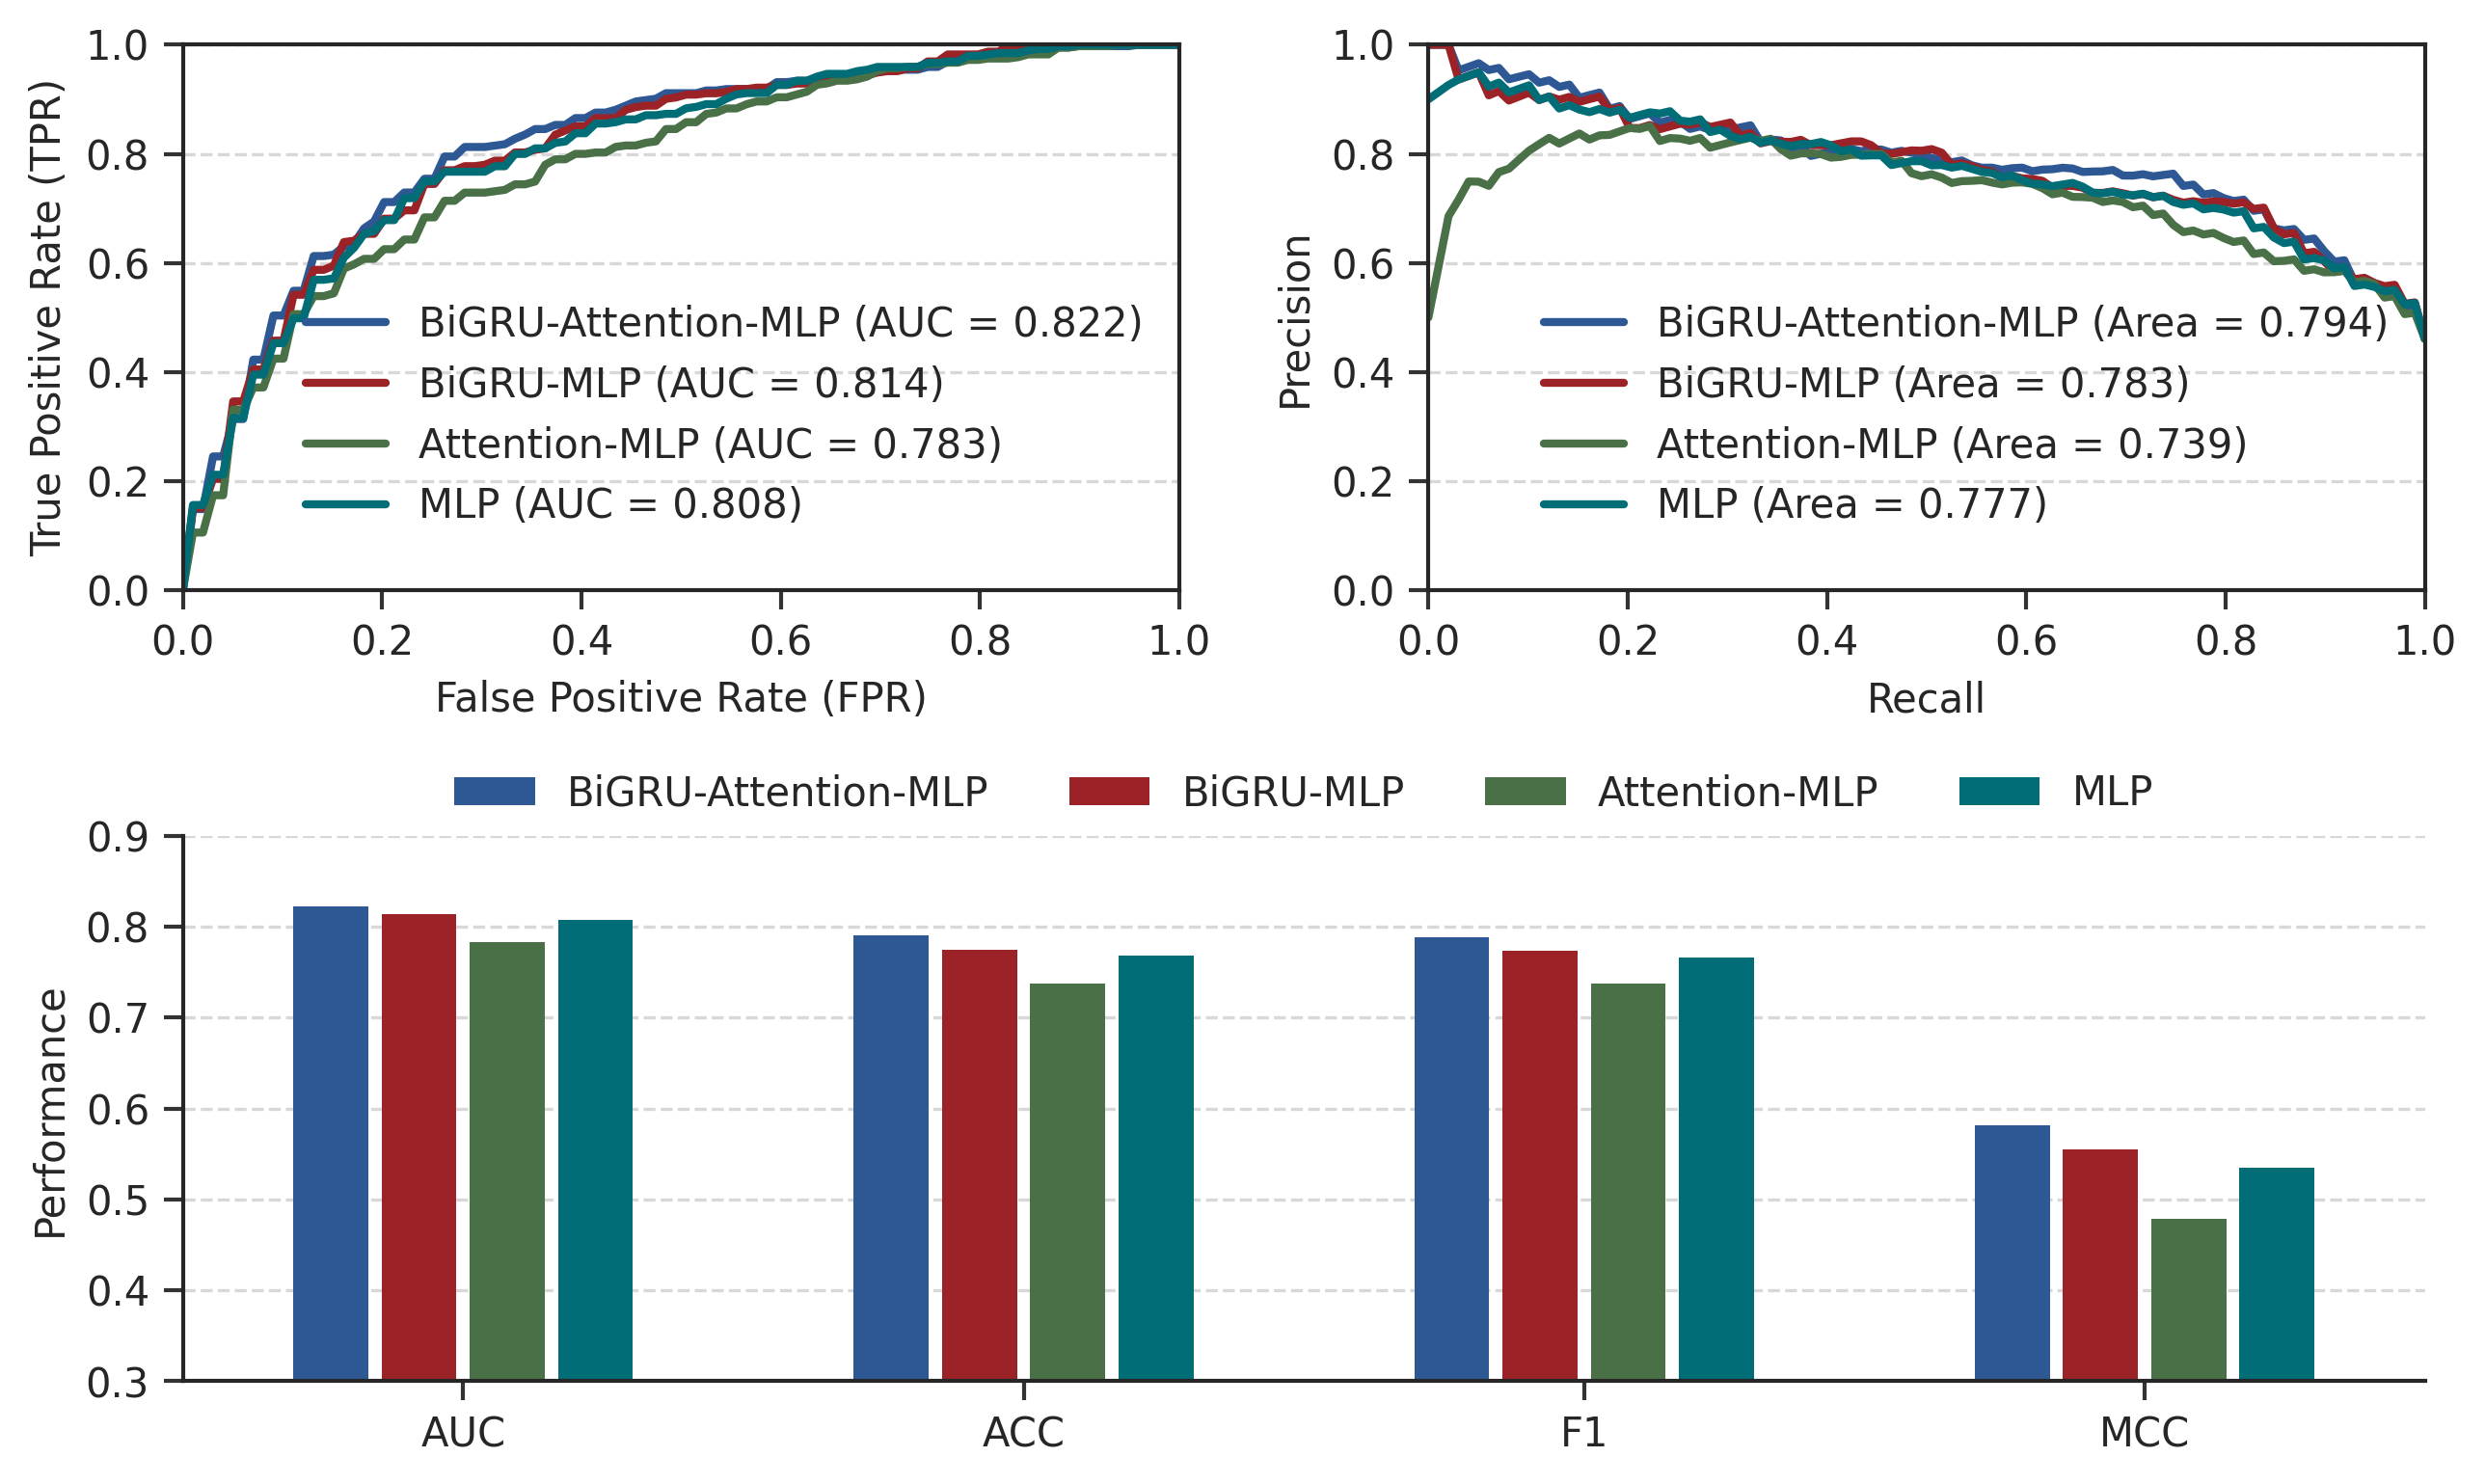

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker
import numpy as np
from matplotlib.patches import Rectangle
import pandas as pd

# ========== 全局样式设置 ==========
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'
sns.set_theme(style="ticks", context="paper")

# 自定义调色板（与第一个图一致）
custom_palette = [
    '#8A9DBA',  # Silver Blue
    '#5C7AA7',  # Light Steel Blue
    '#2E5894',  # Deep Blue
    '#C0392B',  # Red
    '#27AE60'   # Green
]

# ========== 字体大小统一设置 ==========
label_fontsize = 10
tick_labelsize = 10
legend_fontsize = 10
title_fontsize = 10

# ========== 创建图形：紧凑布局 ==========
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(
    2, 2,
    figsize=(10, 6),   
    dpi=300,
    gridspec_kw={'height_ratios': [1, 1], 'width_ratios': [1, 1], 'hspace': 0.45, 'wspace': 0.25}
)

# 删除第四个子图
fig.delaxes(ax4)

# 重新获取第三个子图作为跨列子图
ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=2, fig=fig)

# ========== 子图 A：ROC 曲线 ==========
for model_name, data in results.items():
    ax1.plot(data['mean_fpr'], data['mean_tpr'],
            #  color=custom_palette[list(results.keys()).index(model_name)],
            color=colors[model_name],
             lw=2,
             label=f'{model_name} (AUC = {data["mean_auc"]:.3f})')

# ax1.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.0])
ax1.set_xlabel('False Positive Rate (FPR)', fontsize=label_fontsize)
ax1.set_ylabel('True Positive Rate (TPR)', fontsize=label_fontsize)
ax1.grid(True, axis='y', linestyle='--', alpha=0.3, color='gray', linewidth=0.8)
ax1.set_axisbelow(True)
ax1.tick_params(axis='both', labelsize=tick_labelsize, color='#333333')
ax1.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))
ax1.set_xticks(np.arange(0, 1.2, 0.2))
ax1.set_yticks(np.arange(0, 1.2, 0.2))
# ax1.text(-0.06, 1.08, 'A', transform=ax1.transAxes, fontsize=title_fontsize, fontweight='bold', va='top')

# ========== 子图 B：PRC 曲线 ==========
for model_name, data in results.items():
    ax2.plot(data['mean_recall'], data['mean_precision'],
            #  color=custom_palette[list(results.keys()).index(model_name)],
             color=colors[model_name],
             lw=2,
             label=f'{model_name} (Area = {data["mean_pr_auc"]:.3f})')

ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.0])
ax2.set_xlabel('Recall', fontsize=label_fontsize)
ax2.set_ylabel('Precision', fontsize=label_fontsize)
ax2.grid(True, axis='y', linestyle='--', alpha=0.3, color='gray', linewidth=0.8)
ax2.set_axisbelow(True)
ax2.tick_params(axis='both', labelsize=tick_labelsize, color='#333333')
ax2.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))
ax2.set_xticks(np.arange(0, 1.2, 0.2))
ax2.set_yticks(np.arange(0, 1.2, 0.2))
# ax2.text(-0.06, 1.08, 'B', transform=ax2.transAxes, fontsize=title_fontsize, fontweight='bold', va='top')

# ========== 子图 C：箱线图 ==========

bar = sns.barplot(
    x="Metric", y="Value", hue="Model", data=plot_df,
    palette=colors,  # 使用与子图12一致的颜色
    ax=ax3,
    linewidth=0,
    width=0.63,
    saturation=1.0,
    dodge=True,
    gap=0.15,
    errorbar=None  # 明确指定不显示误差棒
)

ax3.set_xlabel('', fontsize=label_fontsize)
ax3.set_ylabel('Performance', fontsize=label_fontsize)
ax3.set_ylim(0.3, 0.9)

ax3.set_yticks(np.arange(0.3, 0.902, 0.1))

ax3.tick_params(axis='both', labelsize=tick_labelsize, color='#333333')
ax3.grid(True, axis='y', linestyle='--', alpha=0.3, color='gray', linewidth=0.8)
ax3.set_axisbelow(True)
# ax3.text(-0.03, 1.02, 'C', transform=ax3.transAxes, fontsize=title_fontsize, fontweight='bold', va='top')

# ========== 图例统一设置 ==========
legend1 = ax1.legend(
    fontsize=legend_fontsize,
    frameon=False,
    loc='lower right',
    bbox_to_anchor=(1, 0.05)
)

legend2 = ax2.legend(
    fontsize=legend_fontsize,
    frameon=False,
    loc='lower right',
    bbox_to_anchor=(1, 0.05)
)

handles, labels = ax3.get_legend_handles_labels()
ax3.legend(
    handles[:len(colors)],
    labels[:len(colors)],
    fontsize=legend_fontsize,
    frameon=False,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.18),
    ncol=4
)
# 去掉上边框和右边框
sns.despine(ax=ax3, top=True, right=True)

# ========== 布局与保存 ==========
# plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.tight_layout(rect=[0, 0.06, 1, 0.92])
plt.savefig("roc_prc_boxplot_unified.pdf", dpi=300, bbox_inches='tight')
plt.savefig("roc_prc_boxplot_unified.png", dpi=300, bbox_inches='tight')
plt.show()

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

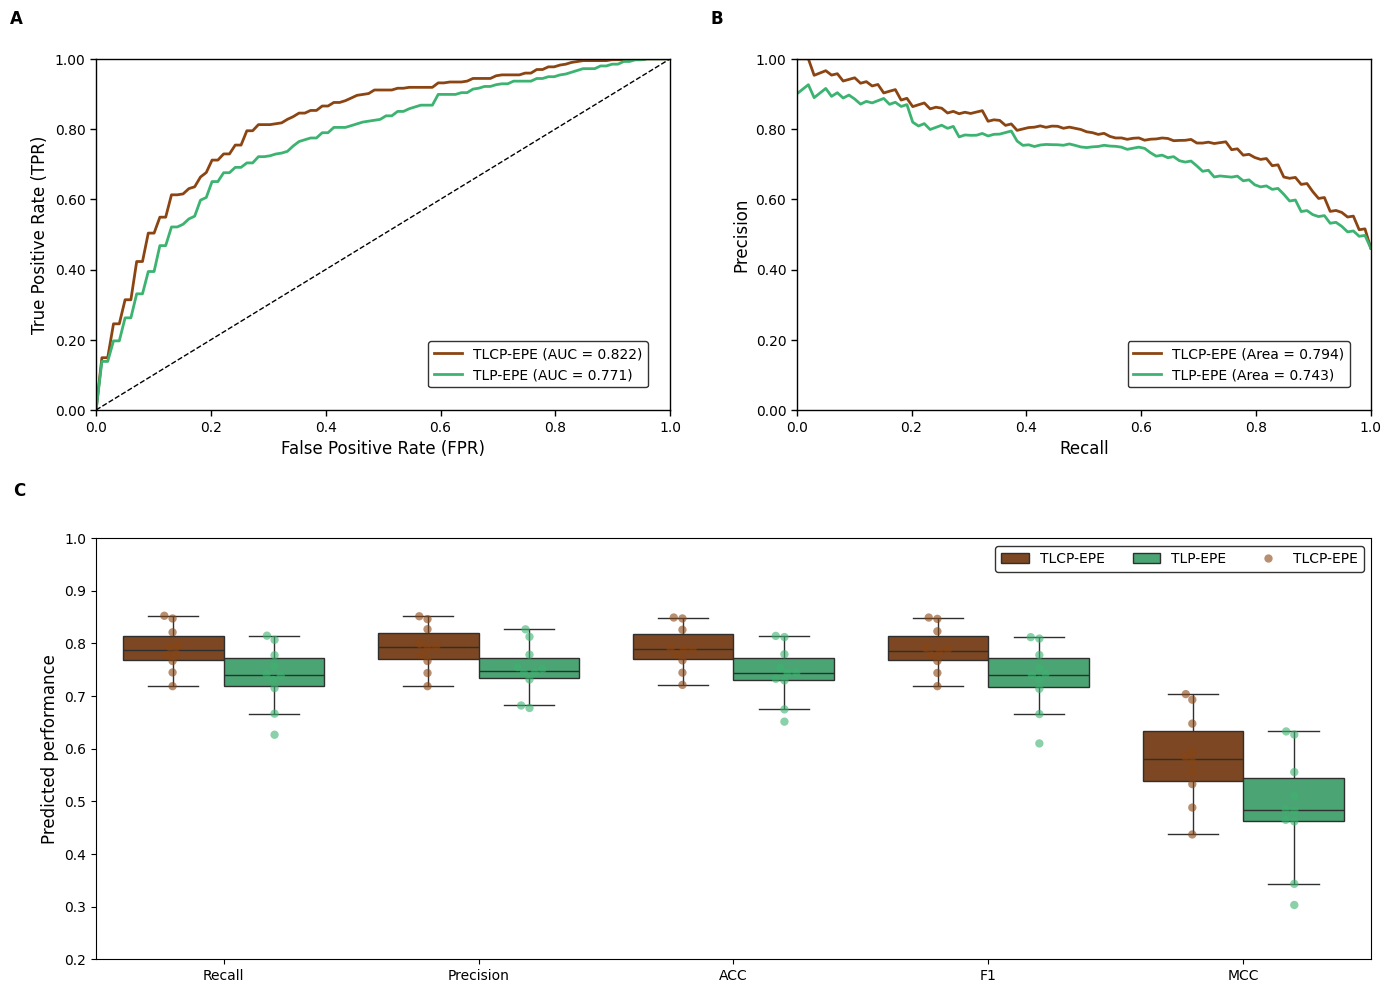

In [35]:
# 设置字体样式为 Arial
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# 创建一个2行2列的图形，C图跨越下面两列
fig = plt.figure(figsize=(14, 10))
gs = plt.GridSpec(2, 2, height_ratios=[1, 1.2])
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[1, :])  # C图跨越整行

# 设置 Seaborn 样式
sns.set_theme(style="ticks", context="paper")
plt.style.use('default')

# 第一个子图 - ROC曲线
for model_name, data in results.items():
    ax1.plot(data['mean_fpr'], data['mean_tpr'], 
            color=colors[model_name], 
            lw=2,
            markersize=6,
            markevery=0.1,
            label=f'{model_name} (AUC = {data["mean_auc"]:.3f})')

# 设置第一个子图的属性
ax1.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.0])
ax1.set_xlabel('False Positive Rate (FPR)', fontsize=12)
ax1.set_ylabel('True Positive Rate (TPR)', fontsize=12)
# ax1.grid(True, axis='y', linestyle='--', alpha=0.3, color='gray')
ax1.grid(False, axis='x')

# 第二个子图 - PRC曲线
for model_name, data in results.items():
    ax2.plot(data['mean_recall'], data['mean_precision'], 
            color=colors[model_name], 
            lw=2,
            markersize=6,
            markevery=0.1,
            label=f'{model_name} (Area = {data["mean_pr_auc"]:.3f})')

# 设置第二个子图的属性
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.0])
ax2.set_xlabel('Recall', fontsize=12 )
ax2.set_ylabel('Precision', fontsize=12)
# ax2.grid(True, axis='y', linestyle='--', alpha=0.3, color='gray')
ax2.grid(False, axis='x')

# 第三个子图 - 箱线图
sns.boxplot(x='Metric', y='Value', hue='Model', data=plot_df,
           palette=colors, width=0.79, showfliers=False, ax=ax3)

sns.swarmplot(x='Metric', y='Value', hue='Model', data=plot_df,
              palette=colors, dodge=True, size=6, alpha=0.6)

# 设置第三个子图的属性
ax3.set_xlabel('', fontsize=12, fontweight='bold')
ax3.set_ylabel('Predicted performance', fontsize=12)
ax3.set_ylim(0.2, 1)

# 设置所有子图的刻度属性
for ax in [ax1, ax2]:
    ax.tick_params(axis='both', which='major', labelsize=10, width=1, length=4)
    ax.tick_params(axis='both', which='minor', width=1, length=2)
    ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))
    
    # 设置刻度范围和间隔
    ax.set_xticks(np.arange(0, 1.2, 0.2))
    ax.set_yticks(np.arange(0, 1.2, 0.2))
    
    # 设置边框线宽
    for spine in ax.spines.values():
        spine.set_linewidth(1)

# 设置图例
legend1 = ax1.legend(
    facecolor='white',
    edgecolor='black',
    fontsize=10,
    title_fontsize=10,
    frameon=True,
    bbox_to_anchor=(0.77, 0.13),
    loc='center'
)

legend2 = ax2.legend(
    facecolor='white',
    edgecolor='black',
    fontsize=10,
    title_fontsize=10,
    frameon=True,
    bbox_to_anchor=(0.77, 0.13),
    loc='center'
)

# 设置第三个子图的图例
handles, labels = ax3.get_legend_handles_labels()
ax3.legend(
    handles[:3],
    labels[:3], 
    facecolor='white',
    edgecolor='black',
    fontsize=10,
    frameon=True,
    loc='center', 
    bbox_to_anchor=(0.85, 0.95),
    ncol=3
)

# 添加子图标签 A、B 和 C
ax1.text(-0.15, 1.1, 'A', transform=ax1.transAxes, fontsize=12, fontweight='bold')
ax2.text(-0.15, 1.1, 'B', transform=ax2.transAxes, fontsize=12, fontweight='bold')
ax3.text(-0.065, 1.1, 'C', transform=ax3.transAxes, fontsize=12, fontweight='bold')

# 调整布局
plt.tight_layout(h_pad=2.0, w_pad=3.0)

# 显示图表
plt.show()     

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

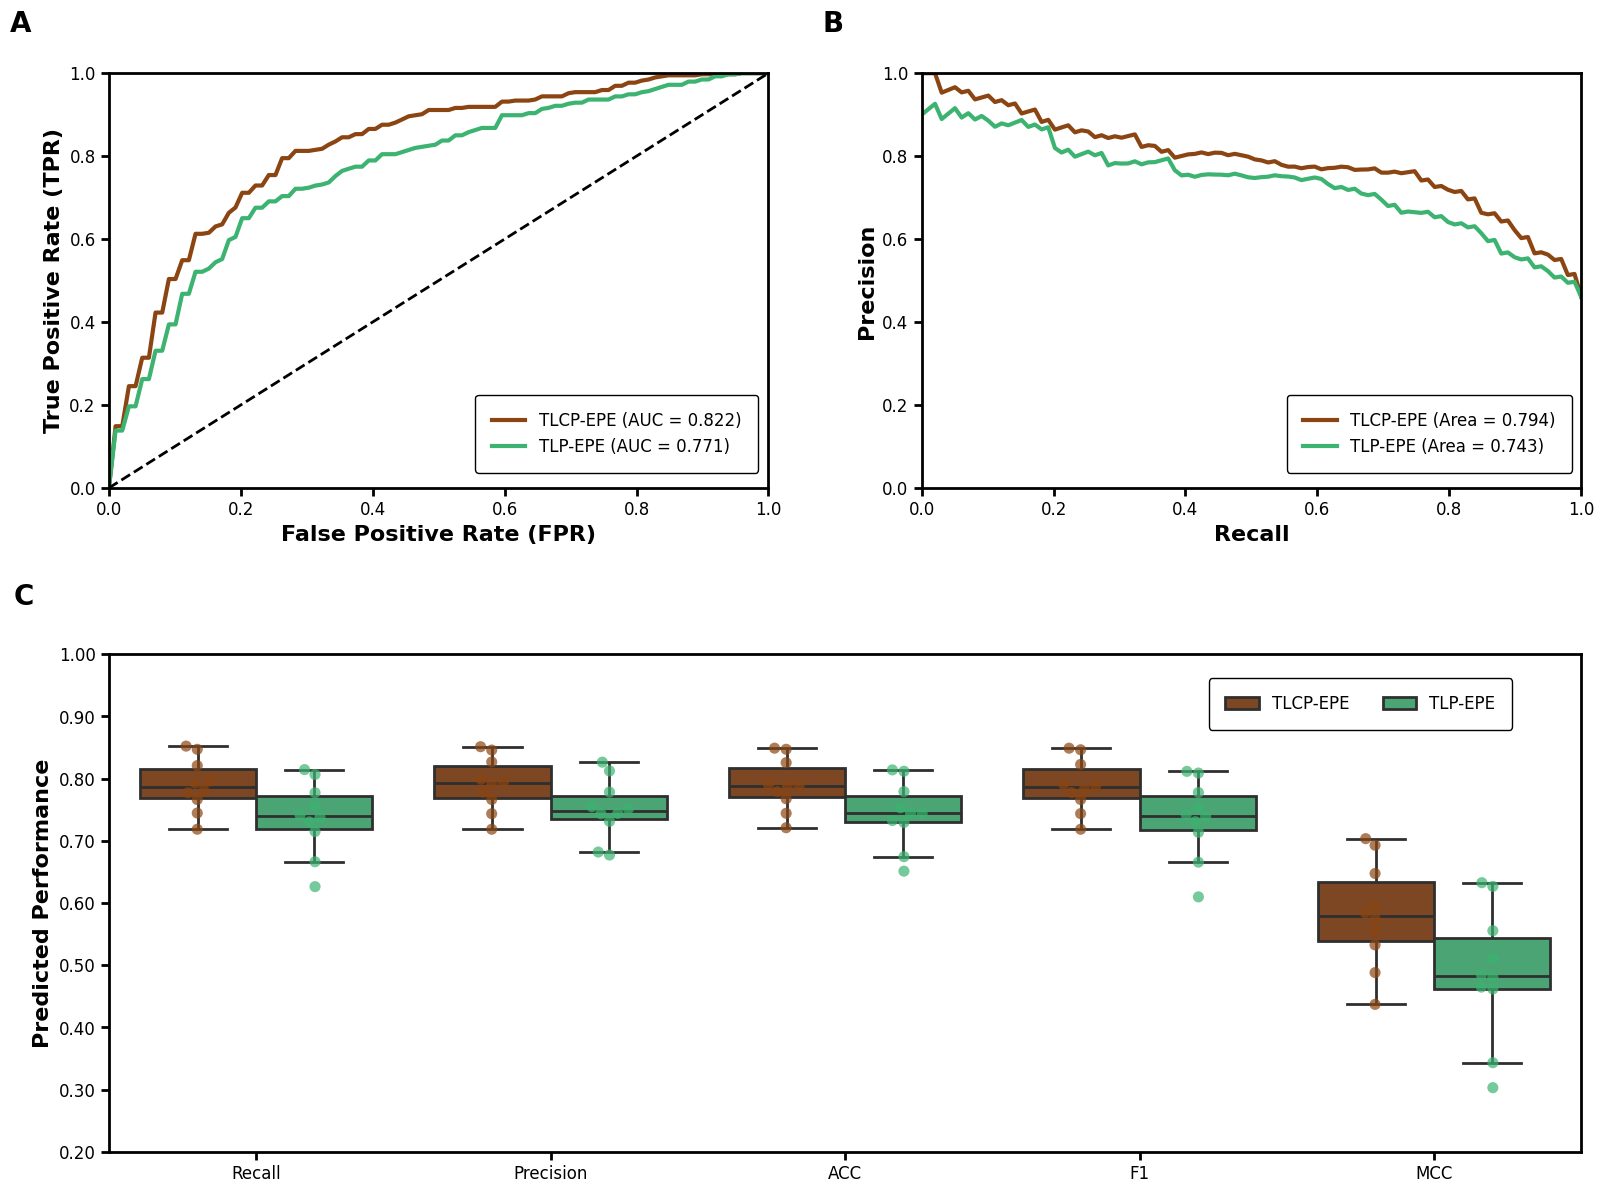

In [40]:
# 设置字体样式为 Arial，增大字体大小
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.size'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12

# 创建一个2行2列的图形，C图跨越下面两列
fig = plt.figure(figsize=(16, 12))
gs = plt.GridSpec(2, 2, height_ratios=[1, 1.2])
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[1, :])  # C图跨越整行

# 设置 Seaborn 样式
sns.set_theme(style="ticks", context="paper")
plt.style.use('default')

# 第一个子图 - ROC曲线
for model_name, data in results.items():
    ax1.plot(data['mean_fpr'], data['mean_tpr'], 
            color=colors[model_name], 
            lw=3,
            markersize=8,
            markevery=0.1,
            label=f'{model_name} (AUC = {data["mean_auc"]:.3f})')

# 设置第一个子图的属性
ax1.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.0])
ax1.set_xlabel('False Positive Rate (FPR)', fontsize=16, fontweight='bold')
ax1.set_ylabel('True Positive Rate (TPR)', fontsize=16, fontweight='bold')
ax1.grid(False, axis='x')

# 第二个子图 - PRC曲线
for model_name, data in results.items():
    ax2.plot(data['mean_recall'], data['mean_precision'], 
            color=colors[model_name], 
            lw=3,
            markersize=8,
            markevery=0.1,
            label=f'{model_name} (Area = {data["mean_pr_auc"]:.3f})')

# 设置第二个子图的属性
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.0])
ax2.set_xlabel('Recall', fontsize=16, fontweight='bold')
ax2.set_ylabel('Precision', fontsize=16, fontweight='bold')
ax2.grid(False, axis='x')

# 第三个子图 - 箱线图
box_plot = sns.boxplot(x='Metric', y='Value', hue='Model', data=plot_df,
                      palette=colors, width=0.79, showfliers=False, ax=ax3, linewidth=2)

swarm_plot = sns.swarmplot(x='Metric', y='Value', hue='Model', data=plot_df,
                          palette=colors, dodge=True, size=8, alpha=0.7)

# 设置第三个子图的属性
ax3.set_xlabel('', fontsize=16, fontweight='bold')
ax3.set_ylabel('Predicted Performance', fontsize=16, fontweight='bold')
ax3.set_ylim(0.2, 1)

# 设置所有子图的刻度属性
for ax_idx, ax in enumerate([ax1, ax2, ax3]):  # 包含ax3
    ax.tick_params(axis='both', which='major', labelsize=12, width=2, length=6)
    ax.tick_params(axis='both', which='minor', width=2, length=4)
    
    # 设置边框线宽
    for spine in ax.spines.values():
        spine.set_linewidth(2)

# 为ax3单独设置y轴格式化
ax3.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))

# 设置图例
legend1 = ax1.legend(
    facecolor='white',
    edgecolor='black',
    fontsize=12,
    title_fontsize=12,
    frameon=True,
    bbox_to_anchor=(0.77, 0.13),
    loc='center',
    framealpha=1.0,
    borderpad=1
)

legend2 = ax2.legend(
    facecolor='white',
    edgecolor='black',
    fontsize=12,
    title_fontsize=12,
    frameon=True,
    bbox_to_anchor=(0.77, 0.13),
    loc='center',
    framealpha=1.0,
    borderpad=1
)

# 设置第三个子图的图例
handles, labels = ax3.get_legend_handles_labels()
ax3.legend(
    handles[:2],
    labels[:2], 
    facecolor='white',
    edgecolor='black',
    fontsize=12,
    frameon=True,
    loc='center', 
    bbox_to_anchor=(0.85, 0.9),
    ncol=3,
    framealpha=1.0,
    borderpad=1
)

# 添加子图标签 A、B 和 C
ax1.text(-0.15, 1.1, 'A', transform=ax1.transAxes, fontsize=20, fontweight='bold')
ax2.text(-0.15, 1.1, 'B', transform=ax2.transAxes, fontsize=20, fontweight='bold')
ax3.text(-0.065, 1.1, 'C', transform=ax3.transAxes, fontsize=20, fontweight='bold')

# 调整布局
plt.tight_layout(h_pad=3.0, w_pad=4.0)

# 显示图表
plt.show()

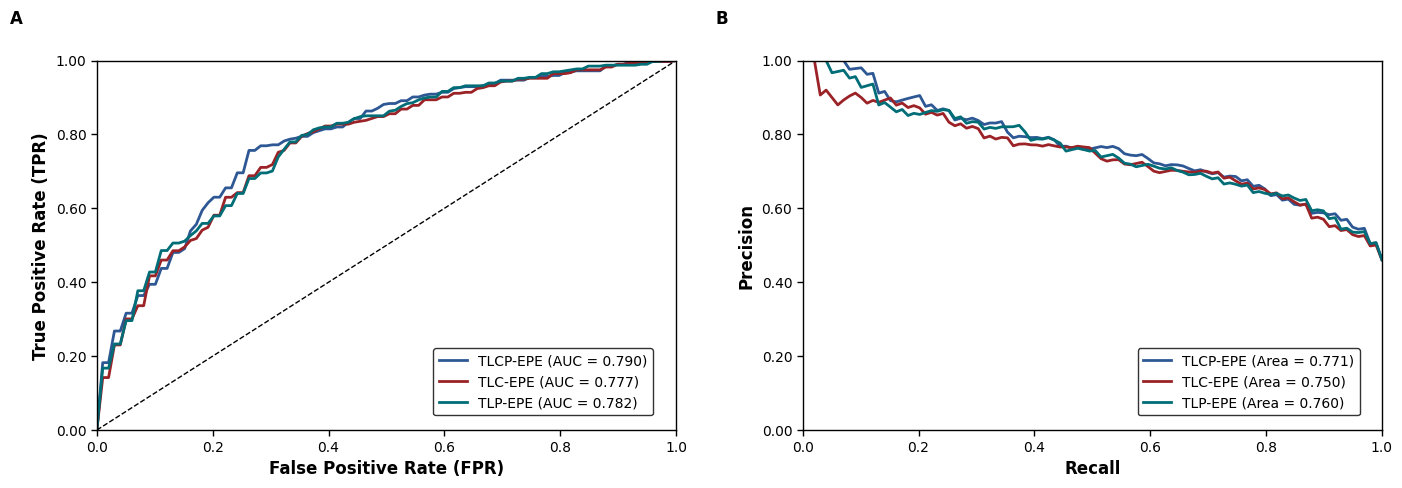

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker
import numpy as np

# Set font style to Arial
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# Set Seaborn style
sns.set_theme(style="ticks", context="paper")
plt.style.use('default')

# Create figure with GridSpec for two subplots
fig = plt.figure(figsize=(14, 5))
gs = plt.GridSpec(1, 2)  # Single row, two columns
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])

# First subplot - ROC curve
for model_name, data in results.items():
    ax1.plot(data['mean_fpr'], data['mean_tpr'], 
             color=colors[model_name], 
             lw=2,
             markersize=6,
             markevery=0.1,
             label=f'{model_name} (AUC = {data["mean_auc"]:.3f})')

# Set first subplot properties
ax1.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.0])
ax1.set_xlabel('False Positive Rate (FPR)', fontsize=12, fontweight='bold')
ax1.set_ylabel('True Positive Rate (TPR)', fontsize=12, fontweight='bold')
ax1.grid(False, axis='x')

# Second subplot - PRC curve
for model_name, data in results.items():
    ax2.plot(data['mean_recall'], data['mean_precision'], 
             color=colors[model_name], 
             lw=2,
             markersize=6,
             markevery=0.1,
             label=f'{model_name} (Area = {data["mean_pr_auc"]:.3f})')

# Set second subplot properties
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.0])
ax2.set_xlabel('Recall', fontsize=12, fontweight='bold')
ax2.set_ylabel('Precision', fontsize=12, fontweight='bold')
ax2.grid(False, axis='x')

# Set tick parameters for both subplots
for ax in [ax1, ax2]:
    ax.tick_params(axis='both', which='major', labelsize=10, width=1, length=4)
    ax.tick_params(axis='both', which='minor', width=1, length=2)
    ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))
    ax.set_xticks(np.arange(0, 1.2, 0.2))
    ax.set_yticks(np.arange(0, 1.2, 0.2))
    for spine in ax.spines.values():
        spine.set_linewidth(1)

# Set legends
legend1 = ax1.legend(
    facecolor='white',
    edgecolor='black',
    fontsize=10,
    title_fontsize=10,
    frameon=True,
    bbox_to_anchor=(0.77, 0.13),
    loc='center'
)

legend2 = ax2.legend(
    facecolor='white',
    edgecolor='black',
    fontsize=10,
    title_fontsize=10,
    frameon=True,
    bbox_to_anchor=(0.77, 0.13),
    loc='center'
)

# Add subplot labels A and B
ax1.text(-0.15, 1.1, 'A', transform=ax1.transAxes, fontsize=12, fontweight='bold')
ax2.text(-0.15, 1.1, 'B', transform=ax2.transAxes, fontsize=12, fontweight='bold')

# Adjust layout
plt.tight_layout(w_pad=3.0)

# Show plot
plt.show()

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

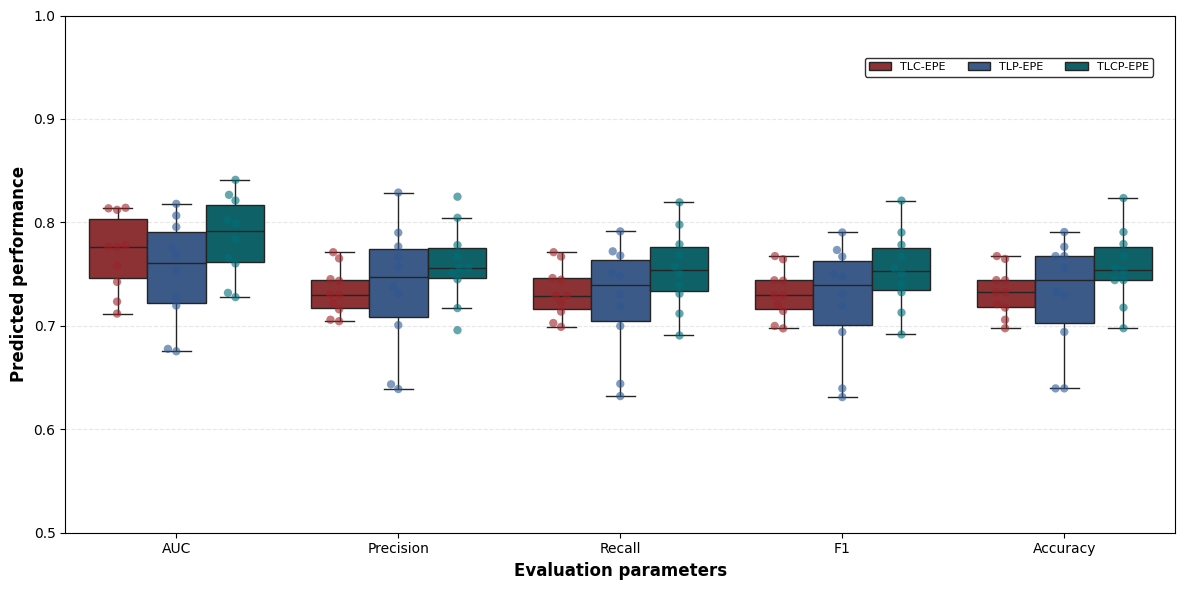

In [33]:
# 设置绘图样式
plt.style.use('default')
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# 创建图形
fig, ax = plt.subplots(figsize=(12, 6))

# 设置颜色
colors = ['#9B2226', '#2E5894', '#006D77']

# 创建箱线图
sns.boxplot(x='Metric', y='Value', hue='Model', data=plot_df,
            palette=colors, width=0.79, showfliers=False)
sns.swarmplot(x='Metric', y='Value', hue='Model', data=plot_df,
              palette=colors, dodge=True, size=6, alpha=0.6)

# 设置图表属性
plt.xlabel('Evaluation parameters', fontsize=12, fontweight='bold')
plt.ylabel('Predicted performance', fontsize=12, fontweight='bold')
plt.ylim(0.5, 1)

# 设置图例（调整为一行）
handles, labels = ax.get_legend_handles_labels()
plt.legend(
    handles[:3],
    labels[:3], 
    facecolor='white',
    edgecolor='black',
    fontsize=8,
    frameon=True,
    loc='center', 
    bbox_to_anchor=(0.85, 0.9),
    ncol=3  # 将图例设置为一行
)

# 设置网格
plt.grid(True, axis='y', linestyle='--', alpha=0.3)
plt.grid(False, axis='x')

# 设置刻度
plt.tick_params(axis='both', which='major', labelsize=10)

# 调整布局
plt.tight_layout()

# 显示图表
plt.show()